# German Speed Limit Sign Recognition with Tensorflow and Keras

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Installation of required libs Scikit Learn, TensorFlow, and Keras

In [3]:
!conda install --name root scikit-learn -y

Fetching package metadata .......
Solving package specifications: ..........

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-env-2.6.0            |                0          502 B

The following packages will be UPDATED:

    conda:     4.2.13-py35_0 conda-forge --> 4.3.16-py35_0

The following packages will be SUPERCEDED by a higher-priority channel:

    conda-env: 2.6.0-0       conda-forge --> 2.6.0-0      

Pruning fetched packages from the cache ...
Fetching packages ...
conda-env-2.6. 100% |################################| Time: 0:00:00 746.38 kB/s
Extracting packages ...
[      COMPLETE      ]|###################################################| 100%
Unlinking packages ...
[      COMPLETE      ]|###################################################| 100%
Linking packages ...
[      COMPLETE      ]|##

In [4]:
from distutils.version import StrictVersion

In [5]:
import sklearn

# should at least be 0.18
assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

sklearn.__version__

'0.18.1'

In [6]:
!conda install --name root -c conda-forge tensorflow -y

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following packages will be SUPERSEDED by a higher-priority channel:

    conda:     4.3.16-py35_0 --> 4.2.13-py35_0 conda-forge
    conda-env: 2.6.0-0       --> 2.6.0-0       conda-forge

conda-env-2.6. 100% |################################| Time: 0:00:00   1.23 MB/s


In [7]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# should at least be 1.0
assert StrictVersion(tf.__version__) >= StrictVersion('1.0.0')

tf.__version__

'1.0.0'

In [8]:
!pip install keras

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import keras as keras

# should at least be 1.2 and use TensorFlow backend
assert StrictVersion(keras.__version__) >= StrictVersion('1.2.2')

keras.__version__

Using TensorFlow backend.


'2.0.3'

## Download data

In [10]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810k  100 1810k    0     0  3605k      0 --:--:-- --:--:-- --:--:-- 3605k  0      0      0 --:--:-- --:--:-- --:--:--     0


In [11]:
# https://docs.python.org/3/library/zipfile.html
from zipfile import ZipFile
zip = ZipFile(r'speed-limit-signs.zip')
zip.extractall('.')

## Prepare Image Data

In [12]:
import os
import skimage.data

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [13]:
# Load datasets.
ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")

images, labels = load_data(data_dir)

In [14]:
import skimage.transform

# Resize images
images64 = [skimage.transform.resize(image, (64, 64))
                for image in images]

In [15]:
import numpy as np

y = np.array(labels)
X = np.array(images64)
y.shape, X.shape

((379,), (379, 64, 64, 3))

## Training using alternative architectures

In [16]:
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [17]:
from sklearn.model_selection import train_test_split

### Split training (80%) from test data (%20) (and make it reproduceable)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### Tower based inception architecture

In [19]:
# tower based inception model
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

tower_1 = Convolution2D(16, (1, 1), padding='same', activation='relu')(inputs)
tower_1 = Convolution2D(16, (3, 3), padding='same', activation='relu')(tower_1)
tower_1 = Dropout(0.5)(tower_1)

tower_2 = Convolution2D(16, (1, 1), padding='same', activation='relu')(inputs)
tower_2 = Convolution2D(16, (5, 5), padding='same', activation='relu')(tower_2)
tower_2 = Dropout(0.5)(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
tower_3 = Convolution2D(16, (1, 1), padding='same', activation='relu')(tower_3)
tower_3 = Dropout(0.5)(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

x = Flatten()(output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(6, activation='softmax')(x)

model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, nb_epoch=80, batch_size=100)

Epoch 1/50
303/303 [==============================] - 4s - loss: 8.4053 - acc: 0.2112     
Epoch 2/50
303/303 [==============================] - 4s - loss: 9.1525 - acc: 0.2409      
Epoch 3/50
303/303 [==============================] - 4s - loss: 4.9935 - acc: 0.2409     
Epoch 4/50
30

In [30]:
# again, if accuracy is still not close to 1, run this as many times as necessary 
model.fit(X_train, y_train, nb_epoch=10, batch_size=100)

Epoch 1/10
303/303 [==============================] - 4s - loss: 0.0709 - acc: 0.9802     
Epoch 2/10
303/303 [==============================] - 4s - loss: 0.0408 - acc: 0.9868     
Epoch 3/10
303/303 [==============================] - 4s - loss: 0.0480 - acc: 0.9802     
Epoch 4/10
303/3

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)
train_loss, train_accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
test_loss, test_accuracy

## Lower accuracy on Test Data than VGG, due to lower depth?

### Let us try a few random samples on the test data

In [90]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

In [92]:
sample_labels

[array([ 0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.])]

In [93]:
# that is a tad hard to read, just choose the category

ground_truth = np.argmax(sample_labels, axis=1)
ground_truth

array([1, 5, 5, 0, 4, 4, 5, 2, 1, 5])

In [94]:
# now make the prediction for the sample inputs
X_sample = np.array(sample_images)
prediction = model.predict(X_sample)

In [95]:
# softmax predictions would be even harder to read, again just choose the hightst category

predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([1, 5, 5, 0, 4, 4, 5, 2, 5, 5])

In [96]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

## Visualizing where we were right (might be up to 9 out of 10)

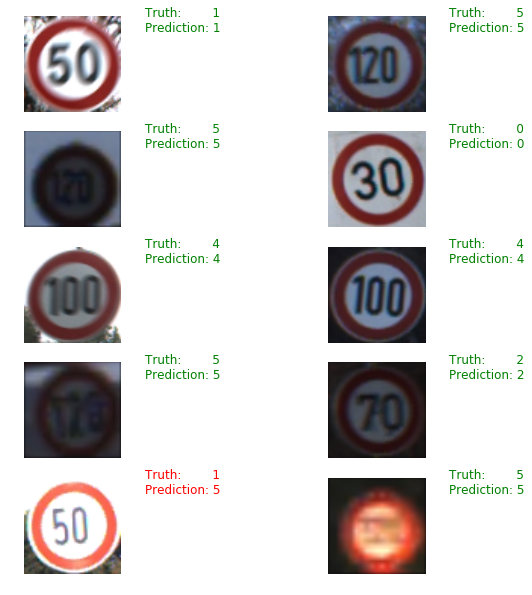

In [97]:
display_prediction(sample_images, ground_truth, predicted_categories)

## Save model for later predictions and comparions

In [98]:
!mkdir models

In [99]:
model.save('models/conv-inception.h5')

In [100]:
# use the Data Menu Item to download from this directory
!ls -l models

total 33868
-rw-r--r-- 1 nbuser nbuser 34676904 Apr 23 10:08 conv-vgg.h5


In [101]:
# https://notebooks.azure.com/faq#download_data
# or use https://transfer.sh/
!curl --upload-file ./models/conv-inception.h5 https://transfer.sh/conv-vgg.h5

https://transfer.sh/xjzxH/conv-vgg.h5